In [78]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from sklearn.metrics import classification_report
import torch.nn as nn
from transformers import BertForSequenceClassification
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# **1. Load Dataset**

In [79]:
def load_text(path):
    texts = []
    labels =[]
    with open(path,'r') as file:
        txts = [x.split(';') for x in file.readlines()]
        for text,label in txts:
            texts.append(text)
            labels.append(label.rstrip('\n'))
    return texts,labels

In [80]:
train_texts,train_labels = load_text('/kaggle/input/emotions-dataset-for-nlp/train.txt') 
test_texts,test_labels = load_text('/kaggle/input/emotions-dataset-for-nlp/test.txt')
val_texts,val_labels = load_text('/kaggle/input/emotions-dataset-for-nlp/val.txt')

In [81]:
print('train labels : ',len(train_labels))
print('test_labels : ',len(test_labels))
print('val_labels : ',len(val_labels))

train labels :  16000
test_labels :  2000
val_labels :  2000


# **2. EDA**

In [82]:
# setting pallete
pal = sns.color_palette('Set3', n_colors=10)
pal[0], pal[1], pal[2], pal[4], pal[3], pal[6] = pal[0], pal[2], pal[3], pal[1], pal[4], pal[6]

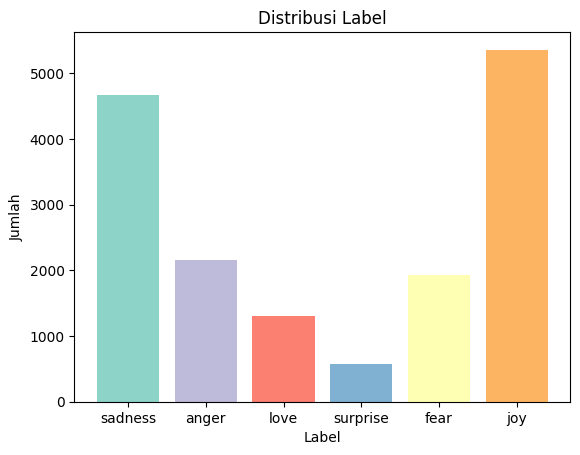

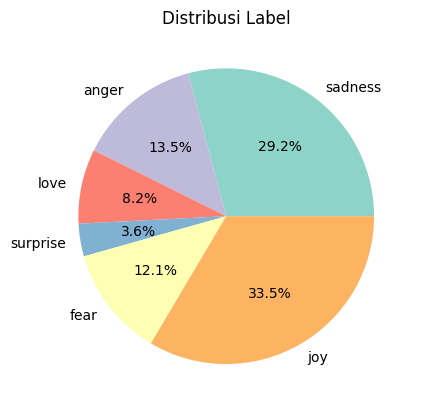

In [83]:
train_labelcount=Counter(train_labels)

plt.bar(train_labelcount.keys(), train_labelcount.values(), color=pal)
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

sns.set_palette(pal)
plt.pie(train_labelcount.values(), labels=train_labelcount.keys(), autopct='%1.1f%%', colors=pal[:len(train_labelcount)])
plt.title("Distribusi Label")
plt.show()

# **3. Label Encoding**

In [84]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [85]:
# val_labels_encoded = list(range(6))  # [0, 1, 2, 3, 4, 5]
# decoded_labels = label_encoder.inverse_transform(val_labels_encoded)
# print(decoded_labels)

In [86]:
# ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']

In [87]:
train_labels_tensor = torch.tensor(train_labels_encoded)
test_labels_tensor = torch.tensor(test_labels_encoded)
val_labels_tensor = torch.tensor(val_labels_encoded)

# **4. Tokenisasi dengan BertTokenizer**

In [88]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_inputs = tokenizer(train_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
val_inputs = tokenizer(val_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
test_inputs = tokenizer(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [89]:
print(train_inputs)

{'input_ids': tensor([[  101,  1045,  2134,  ...,     0,     0,     0],
        [  101,  1045,  2064,  ...,     0,     0,     0],
        [  101, 10047,  9775,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2113,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


# **5. Tensor Dataset dan DataLoader**

In [90]:
# Membuat TensorDataset
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels_tensor)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels_tensor)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels_tensor)


In [91]:
# DataLoader untuk batching
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)

# **6. Modeling dengan Bert Classification**

In [92]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [93]:
# Hyperparameter
epochs = 3
learning_rate = 2e-5

total_train_loss = []
total_val_loss = []

# Optimizer and Loss Function
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [94]:
# Fungsi Training
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(train_loader, desc="Training", leave=False):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

In [95]:
# Fungsi Evaluasi
def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating", leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(val_loader), accuracy

In [96]:
# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_accuracy = train_one_epoch(model, train_dataloader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/3


Train Loss: 0.3757, Train Accuracy: 0.8681
Val Loss: 0.1880, Val Accuracy: 0.9255
Epoch 2/3


Train Loss: 0.1493, Train Accuracy: 0.9356
Val Loss: 0.1820, Val Accuracy: 0.9225
Epoch 3/3


Train Loss: 0.1213, Train Accuracy: 0.9391
Val Loss: 0.1537, Val Accuracy: 0.9375


In [97]:
# Evaluasi Test Data
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing", leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, all_labels, all_preds


In [98]:
test_accuracy, all_labels, all_preds = test_model(model, test_dataloader)

Test Accuracy: 0.9300


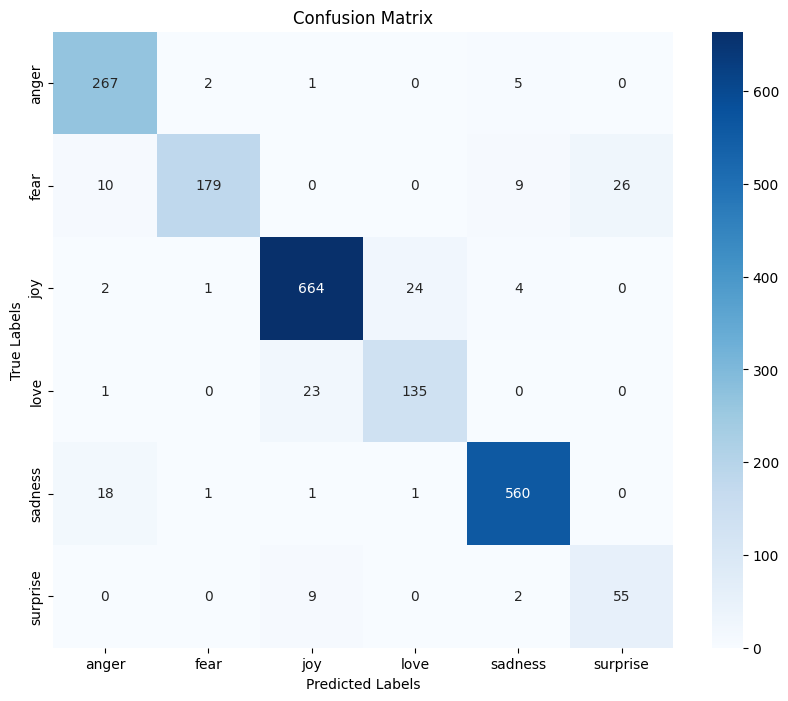

In [99]:
# Confusion Matrix
decoded_alllabels = label_encoder.inverse_transform(all_labels)
decoded_allpreds = label_encoder.inverse_transform(all_preds)
cm = confusion_matrix(decoded_alllabels, decoded_allpreds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

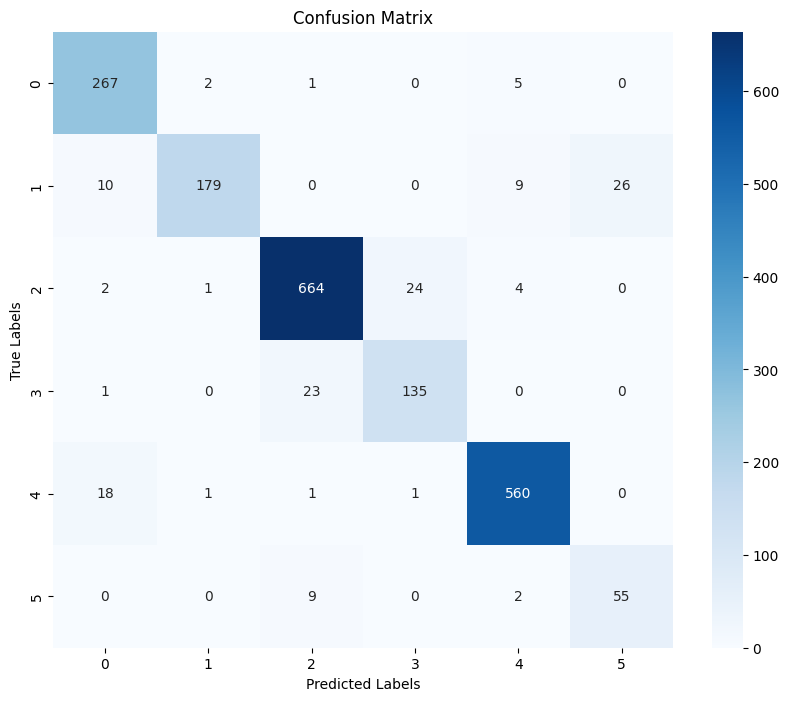

In [100]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [101]:
# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(6)]))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       275
     Class 1       0.98      0.80      0.88       224
     Class 2       0.95      0.96      0.95       695
     Class 3       0.84      0.85      0.85       159
     Class 4       0.97      0.96      0.96       581
     Class 5       0.68      0.83      0.75        66

    accuracy                           0.93      2000
   macro avg       0.89      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



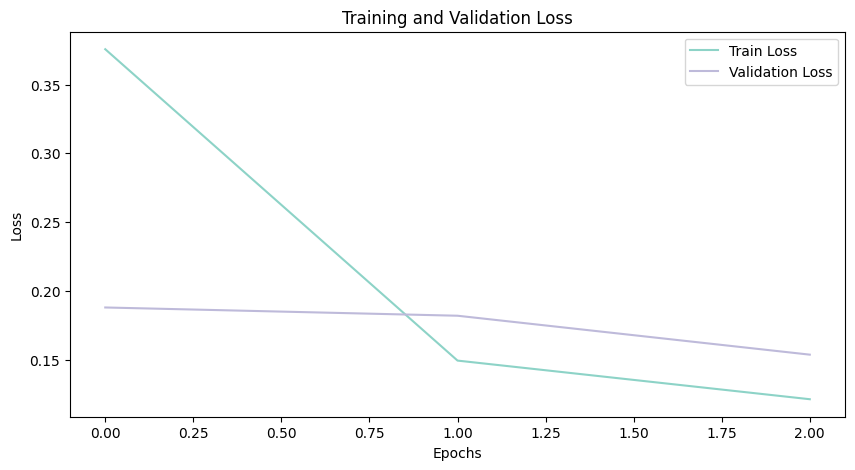

In [102]:
# Visualisasi
plt.figure(figsize=(10, 5))
plt.plot(total_train_loss, label="Train Loss")
plt.plot(total_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [103]:
import pickle
# Save Model with Pickle
with open("bert_sequence_classification_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("Model saved as bert_sequence_classification_model.pkl")


Model saved as bert_sequence_classification_model.pkl


In [104]:
# Fungsi untuk prediksi teks

def predict_text(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

    predicted_label = label_encoder.inverse_transform(preds.cpu().numpy())  # Pastikan prediksi ada di CPU
    return predicted_label[0]

In [105]:
sample_text = "i hate him"
predicted_label = predict_text(sample_text, model, tokenizer)
print(f"Predicted label for the input text: {predicted_label}")

Predicted label for the input text: anger
